# House Price Prediction in India

### Abstract
In this notebook, I have tried to predict the house prices in India.

In [ ]:
# Importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

## Data Overview

In [ ]:
# Loading the data

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5
...,...,...,...,...,...,...,...,...,...,...,...,...
29446,Owner,0,0,3,BHK,2500.000000,1,1,"Shamshabad Road,Agra",27.140626,78.043277,45.0
29447,Owner,0,0,2,BHK,769.230769,1,1,"E3-108, Lake View Recidency,,Vapi",39.945409,-86.150721,16.0
29448,Dealer,0,0,2,BHK,1022.641509,1,1,"Ajmer Road,Jaipur",26.928785,75.828002,27.1
29449,Owner,0,0,2,BHK,927.079009,1,1,"Sholinganallur,Chennai",12.900150,80.227910,67.0


In [ ]:
# Seeing the first 5 entries of the data

train.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


## Understanding data

In [ ]:
# This returns the shape of the dataset

train.shape

(29451, 12)

In [ ]:
# This return us the column names

train.columns

Index(['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'BHK_OR_RK',
       'SQUARE_FT', 'READY_TO_MOVE', 'RESALE', 'ADDRESS', 'LONGITUDE',
       'LATITUDE', 'TARGET(PRICE_IN_LACS)'],
      dtype='object')

In [ ]:
# This returns the data types of each columns in our dataset

train.dtypes

POSTED_BY                 object
UNDER_CONSTRUCTION         int64
RERA                       int64
BHK_NO.                    int64
BHK_OR_RK                 object
SQUARE_FT                float64
READY_TO_MOVE              int64
RESALE                     int64
ADDRESS                   object
LONGITUDE                float64
LATITUDE                 float64
TARGET(PRICE_IN_LACS)    float64
dtype: object

In [ ]:
# By this we can see if there are entries which has null values

train.isnull().sum()

POSTED_BY                0
UNDER_CONSTRUCTION       0
RERA                     0
BHK_NO.                  0
BHK_OR_RK                0
SQUARE_FT                0
READY_TO_MOVE            0
RESALE                   0
ADDRESS                  0
LONGITUDE                0
LATITUDE                 0
TARGET(PRICE_IN_LACS)    0
dtype: int64

In [ ]:
# This returns us the information of our dataset

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29451 entries, 0 to 29450
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   POSTED_BY              29451 non-null  object 
 1   UNDER_CONSTRUCTION     29451 non-null  int64  
 2   RERA                   29451 non-null  int64  
 3   BHK_NO.                29451 non-null  int64  
 4   BHK_OR_RK              29451 non-null  object 
 5   SQUARE_FT              29451 non-null  float64
 6   READY_TO_MOVE          29451 non-null  int64  
 7   RESALE                 29451 non-null  int64  
 8   ADDRESS                29451 non-null  object 
 9   LONGITUDE              29451 non-null  float64
 10  LATITUDE               29451 non-null  float64
 11  TARGET(PRICE_IN_LACS)  29451 non-null  float64
dtypes: float64(4), int64(5), object(3)
memory usage: 2.7+ MB


In [ ]:
# This gives the mean, median, etc of the numerical data present in our dataset.

train.describe()

,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
count,29451.000000,29451.000000,29451.000000,2.945100e+04,29451.000000,29451.000000,29451.000000,29451.000000,29451.000000
mean,0.179756,0.317918,2.392279,1.980217e+04,0.820244,0.929578,21.300255,76.837695,142.898746
std,0.383991,0.465675,0.879091,1.901335e+06,0.383991,0.255861,6.205306,10.557747,656.880713
min,0.000000,0.000000,1.000000,3.000000e+00,0.000000,0.000000,-37.713008,-121.761248,0.250000
25%,0.000000,0.000000,2.000000,9.000211e+02,1.000000,1.000000,18.452663,73.798100,38.000000
50%,0.000000,0.000000,2.000000,1.175057e+03,1.000000,1.000000,20.750000,77.324137,62.000000
75%,0.000000,1.000000,3.000000,1.550688e+03,1.000000,1.000000,26.900926,77.828740,100.000000
max,1.000000,1.000000,20.000000,2.545455e+08,1.000000,1.000000,59.912884,152.962676,30000.000000


## Preprocessing data

In [ ]:
# We are splitting the City and storing it in a column

train['CITY'] = train['ADDRESS'].apply(lambda x: x.split(',')[-1])

In [ ]:
# We are splitting the Town and storing it in a column

train['TOWN'] = train['ADDRESS'].apply(lambda x: x.split(',')[-2])

In [ ]:
# We are converting the string values to its corresponding integer values which would help us in the prediction

train['POSTED_BY']= train['POSTED_BY'].replace({'Owner':0, 'Dealer':1, 'Builder':2})

In [ ]:
# We are adding a column namely City tier according to their cities

tier_1 = ["Ahmedabad", "Bangalore", "Chennai", "Delhi", "Hyderabad", "Kolkata", "Mumbai", "Pune"]
tier_2 = ["Agra", "Ajmer", "Aligarh", "Amravati", "Amritsar", "Asansol", "Aurangabad", "Bareilly", "Belgaum", "Bhavnagar", "Bhiwandi", "Bhopal", "Bhubaneswar","Bikaner", "Bilaspur", "Bokaro Steel City","Chandigarh", "Coimbatore", "Cuttack"," Dehradun","Dhanbad", "Bhilai","Durgapur", "Erode", "Faridabad", "Firozabad", "Ghaziabad","Gorakhpur", "Gulbarga", "Guntur", "Gwalior", "Gurugram", "Guwahati", "Hamirpur", "Hubli–Dharwad", "Indore", "Jabalpur", "Jaipur", "Jalandhar", "Jalgaon", "Jammu", "Jamnagar", "Jamshedpur", "Jhansi", "Jodhpur","Navi Mumbai" ,"Kakinada", "Kannur"," Kanpur", "Karnal", "Kochi"," Kolhapur", "Kollam", "Kozhikode", "Kurnool", "Ludhiana","Lucknow","Madurai", "Malappuram"," Mathura", "Mangalore", "Meerut", "Moradabad", "Mysore", "Nagpur"," Nanded"," Nashik", "Nellore","Navi Mumbai","Noid", "Patna", "Puducherry", "Purulia", "Prayagraj", "Raipur","Rajkot", "Rajamahendravaram"," Ranchi", "Rourkela", "Ratlam", "Salem", "Sangli", "Shimla", "Siliguri"," Solapur", "Srinagar", "Surat", "Thanjavur", "Thiruvananthapuram", "Thrissur", "Tiruchirappalli", "Tirunelveli", "Tiruvannamalai", "Ujjain", "Vijayapura", "Vadodara", "Varanasi", "Vasai-Virar City", "Vijayawada", "Visakhapatnam", "Vellore", "Warangal"]

def mapping_city(city):

    if city in tier_1:
        return 1

    elif city in tier_2:
        return 2
        
    else:
        return 3

train['CITY_TIER'] = train['CITY'].apply(mapping_city)

## EDA

In [ ]:
# We are plotting the value counts and its bar plots

train['POSTED_BY'].value_counts()

1    18291
0    10538
2      622
Name: POSTED_BY, dtype: int64

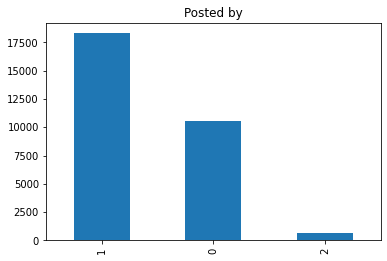

In [ ]:
# This bar plot shows us the value counts of houses posted by Owners, Dealers and Builder

train['POSTED_BY'].value_counts().plot(kind = 'bar', title = 'Posted by')

In [ ]:
train['UNDER_CONSTRUCTION'].value_counts()

0    24157
1     5294
Name: UNDER_CONSTRUCTION, dtype: int64

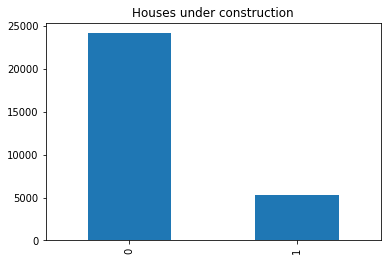

In [ ]:
# This bar plot shows us the value counts of houses under construction

train['UNDER_CONSTRUCTION'].value_counts().plot(kind = 'bar', title = 'Houses under construction')

In [ ]:
train['RERA'].value_counts()

0    20088
1     9363
Name: RERA, dtype: int64

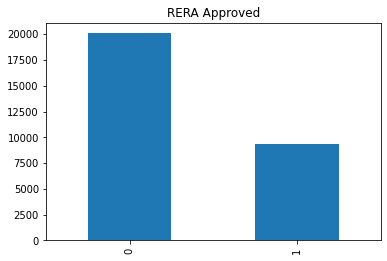

In [ ]:
# This bar plot shows us the value count of houses which have been approved by RERA


train['RERA'].value_counts().plot(kind = 'bar', title = 'RERA Approved')

In [ ]:
train['BHK_NO.'].value_counts()

2     13324
3     10546
1      3574
4      1723
5       190
6        52
7        11
8        10
15        4
10        4
20        4
12        3
9         3
13        1
11        1
17        1
Name: BHK_NO., dtype: int64

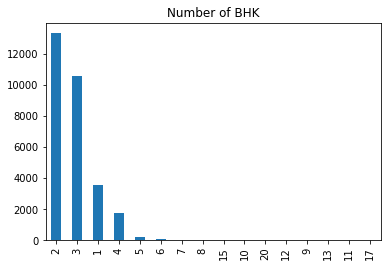

In [ ]:
# This bar plot shows us the value count of houses with respect to the number of BHK

train['BHK_NO.'].value_counts().plot(kind = 'bar', title = 'Number of BHK')

In [ ]:
train['BHK_OR_RK'].value_counts()

BHK    29427
RK        24
Name: BHK_OR_RK, dtype: int64

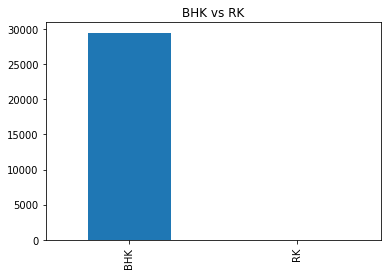

In [ ]:
# This bar plot shows us the value count of houses with BHK or RK(Room Kitchen)

train['BHK_OR_RK'].value_counts().plot(kind = 'bar', title = 'BHK vs RK')

In [ ]:
train['SQUARE_FT'].value_counts()

1000.000000    479
1250.000000    294
800.000000     202
1200.000000    179
1600.000000    125
              ... 
1749.908859      1
1684.001981      1
1864.207221      1
1383.862040      1
1532.889018      1
Name: SQUARE_FT, Length: 19561, dtype: int64

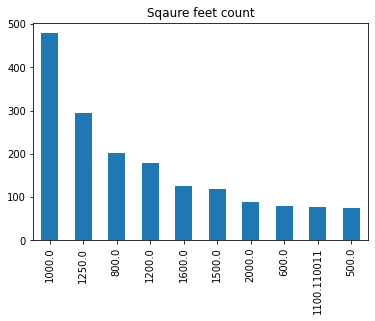

In [ ]:
# This bar plot shows us the value count of houses with respect to house’s square feet

train['SQUARE_FT'].value_counts().iloc[:10].plot(kind = 'bar', title = 'Sqaure feet count')

In [ ]:
train['READY_TO_MOVE'].value_counts()

1    24157
0     5294
Name: READY_TO_MOVE, dtype: int64

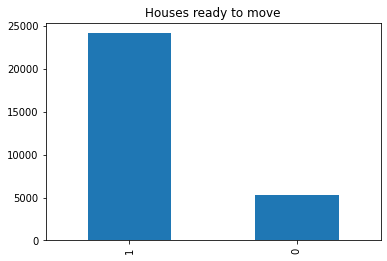

In [ ]:
# This bar plot shows us the value count of houses which are available to move in

train['READY_TO_MOVE'].value_counts().plot(kind = 'bar', title = 'Houses ready to move')

In [ ]:
train['RESALE'].value_counts()

1    27377
0     2074
Name: RESALE, dtype: int64

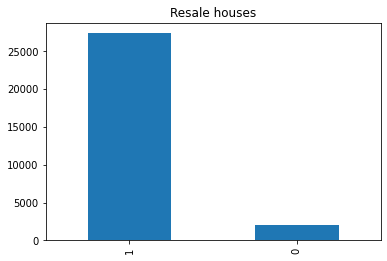

In [ ]:
# This bar plot shows us the value count of houses which are posted for resale

train['RESALE'].value_counts().plot(kind = 'bar', title= 'Resale houses')

In [ ]:
train['TOWN'].value_counts()

Zirakpur                                        563
Whitefield                                      230
Raj Nagar Extension                             215
Thane West                                      165
Kolshet Road                                    153
                                               ... 
Kamshet                                           1
Royal Nagar                                       1
Brahmin Street Near To Mahila Police Station      1
dahiwali                                          1
Sector-2 Kopar Khairane                           1
Name: TOWN, Length: 5897, dtype: int64

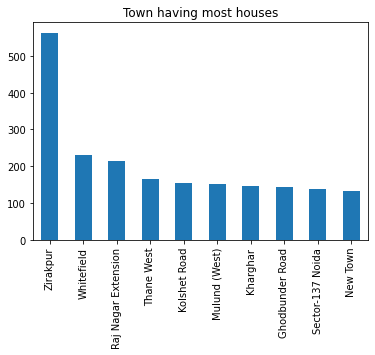

In [ ]:
# This bar plot shows us the town with most houses

train['TOWN'].value_counts()[:10].plot(kind = 'bar', title = 'Town having most houses')

Inferece drawn: Most of the houses are there in Zirakpur (town)

In [ ]:
train['CITY'].value_counts()

Bangalore    4340
Lalitpur     2993
Mumbai       2023
Pune         1991
Noida        1767
             ... 
Cuddalore       1
Pali            1
Siwan           1
Vidisha         1
Faizabad        1
Name: CITY, Length: 256, dtype: int64

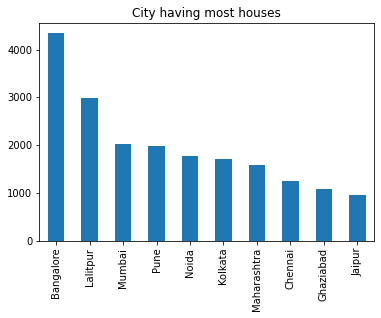

In [ ]:
# This bar plot shows us the city with most houses

train['CITY'].value_counts()[:10].plot(kind = 'bar', title = 'City having most houses')

Inference drawn: Bangalore has most of the houses (city)

In [ ]:
train.groupby(['CITY']).sum().UNDER_CONSTRUCTION.nlargest(10)

CITY
Lalitpur       802
Mumbai         586
Bangalore      550
Maharashtra    495
Pune           383
Kolkata        281
Noida          251
Chandigarh     201
Chennai        157
Mohali         142
Name: UNDER_CONSTRUCTION, dtype: int64

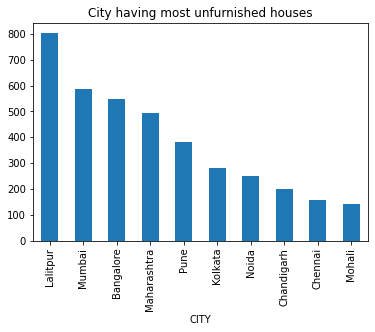

In [ ]:
# This bar plot shows us the city which has most unfurnished house

train.groupby(['CITY']).sum().UNDER_CONSTRUCTION.nlargest(10).plot(kind = 'bar', title = 'City having most unfurnished houses')
plt.show()

Inference drawn: Lalitpur has more unfurnished houses

In [ ]:
train['TOWN'].value_counts()

Zirakpur                                        563
Whitefield                                      230
Raj Nagar Extension                             215
Thane West                                      165
Kolshet Road                                    153
                                               ... 
Kamshet                                           1
Royal Nagar                                       1
Brahmin Street Near To Mahila Police Station      1
dahiwali                                          1
Sector-2 Kopar Khairane                           1
Name: TOWN, Length: 5897, dtype: int64

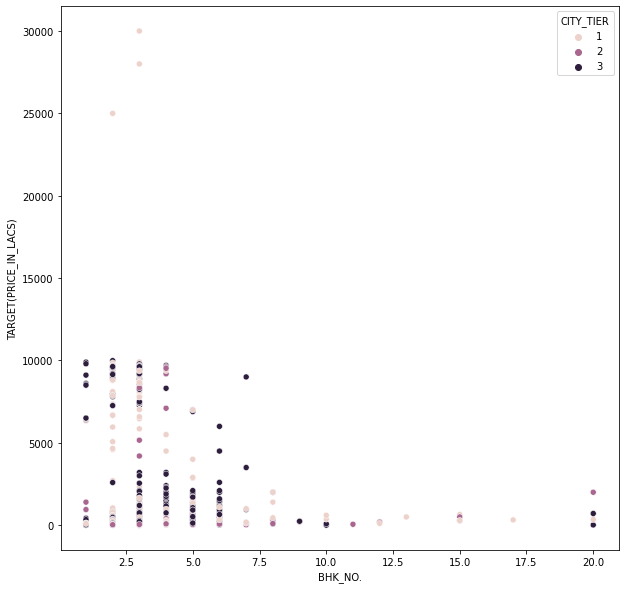

In [ ]:
# This scatter plot shows us the BHK number vs price with respect to their city tiers.

plt.figure(figsize = (10,10))
sns.scatterplot(data=train , hue='CITY_TIER',y='TARGET(PRICE_IN_LACS)',x='BHK_NO.')

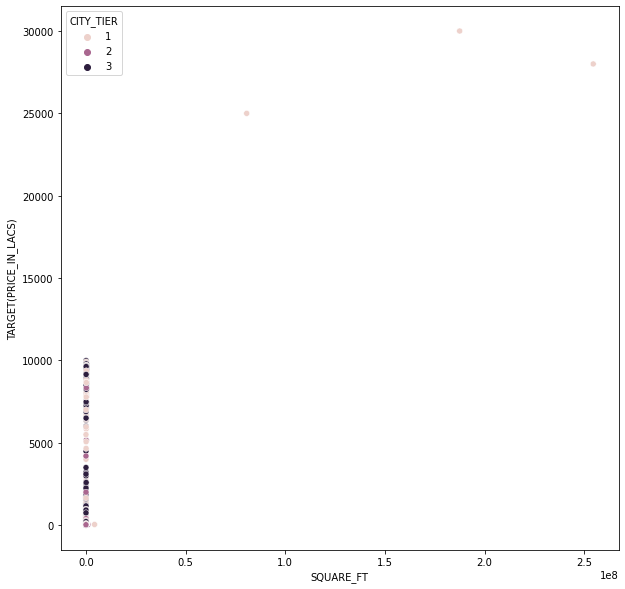

In [ ]:
# This scatter plot shows us the price vs square feet with respect to their city tiers

plt.figure(figsize = (10,10))
sns.scatterplot(data=train , hue='CITY_TIER',y='TARGET(PRICE_IN_LACS)',x='SQUARE_FT')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


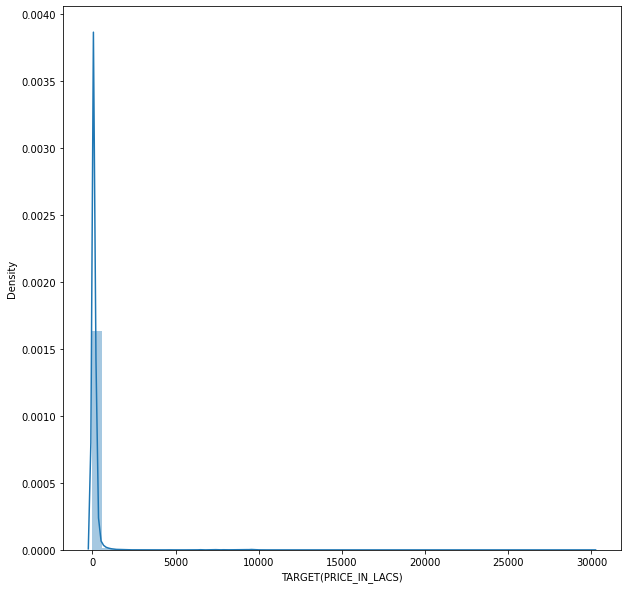

In [ ]:
# This distribution plot shows us the distribution of price

plt.figure(figsize = (10,10))
sns.distplot(train['TARGET(PRICE_IN_LACS)'])

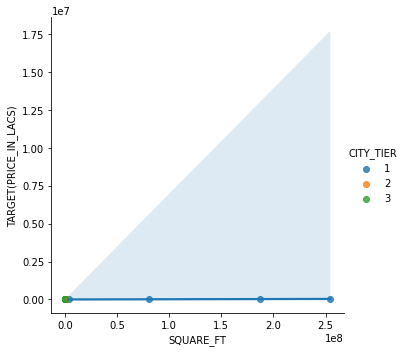

In [ ]:
# This line plot shows us the price vs square feet with respect to their city tiers

sns.lmplot(data=train , hue='CITY_TIER',y='TARGET(PRICE_IN_LACS)',x='SQUARE_FT')

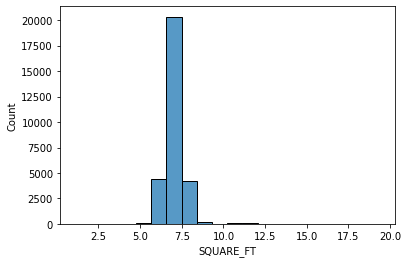

In [ ]:
# This histogram plot shows the log of square feet

sns.histplot(np.log(train['SQUARE_FT']), bins=20)

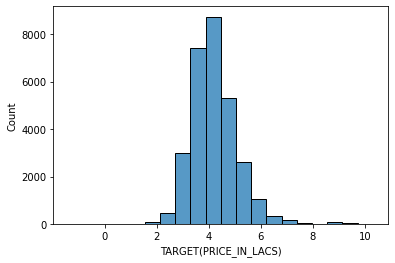

In [ ]:
# This histogram plot shows the log of price

sns.histplot(np.log(train['TARGET(PRICE_IN_LACS)']), bins=20)

In [ ]:
train[train['CITY_TIER'] == 1]

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),CITY,TOWN,CITY_TIER
0,0,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0,Bangalore,Ksfc Layout,1
2,0,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0,Bangalore,Jigani,1
4,1,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5,Kolkata,New Town,1
8,1,0,1,2,BHK,1040.000000,1,1,"Bileshivale,Bangalore",13.054202,77.674002,41.6,Bangalore,Bileshivale,1
9,0,0,1,2,BHK,879.120879,1,1,"Chromepet,Chennai",12.951610,80.140970,36.0,Chennai,Chromepet,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29433,0,0,0,2,BHK,1195.028681,1,1,"Hulimavu,Bangalore",12.876691,77.599080,50.0,Bangalore,Hulimavu,1
29436,0,1,1,2,BHK,1175.132676,0,1,"Whitefield,Bangalore",12.995893,77.761394,62.0,Bangalore,Whitefield,1
29437,1,0,0,2,BHK,760.116253,1,1,"Nandi Bagan,Kolkata",22.541110,88.337780,34.0,Kolkata,Nandi Bagan,1
29444,1,1,1,1,BHK,752.049334,0,1,"Mulund (West),Mumbai",19.175900,72.952200,100.0,Mumbai,Mulund (West),1


We can see the prices in cities

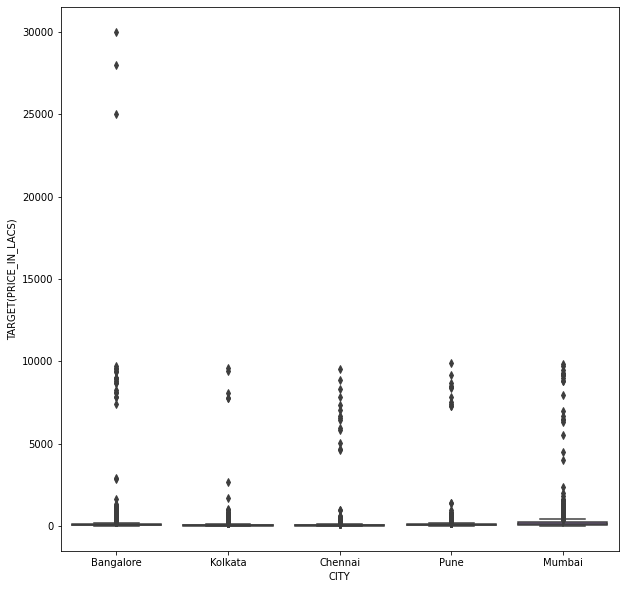

In [ ]:
# This box plot shows us the price of the houses in Tier 1 cities

plt.figure(figsize = (10,10))
sns.boxplot(x = "CITY", y = "TARGET(PRICE_IN_LACS)", data = train[train['CITY_TIER'] == 1])

Box plots of the prices of houses in Top cities

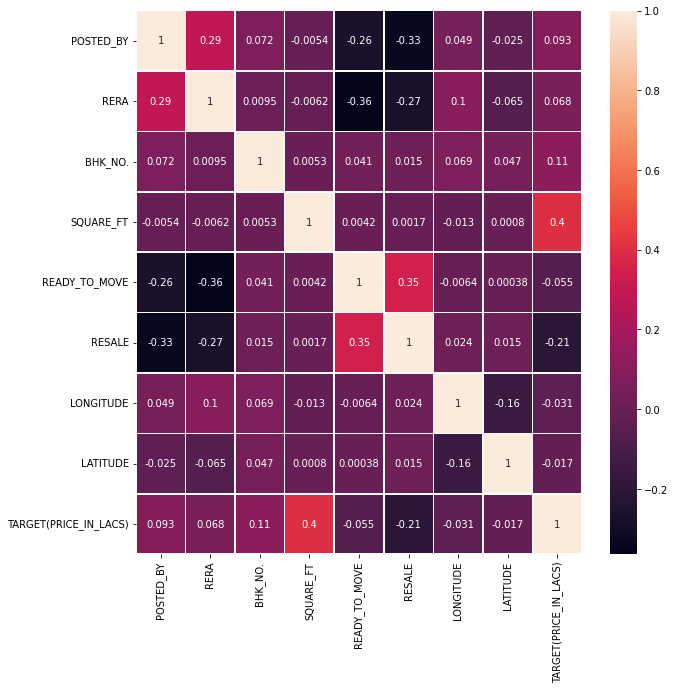

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(train.drop(["UNDER_CONSTRUCTION","CITY_TIER"], axis = 1).corr(), annot= True, linewidth= .5)

In [ ]:
train.corr()['TARGET(PRICE_IN_LACS)']

POSTED_BY                0.093328
UNDER_CONSTRUCTION       0.055399
RERA                     0.067636
BHK_NO.                  0.112283
SQUARE_FT                0.402685
READY_TO_MOVE           -0.055399
RESALE                  -0.207378
LONGITUDE               -0.031112
LATITUDE                -0.017254
TARGET(PRICE_IN_LACS)    1.000000
CITY_TIER                0.011816
Name: TARGET(PRICE_IN_LACS), dtype: float64

## Preprocessing Test data

In [ ]:
# We are splitting the City and storing it in a column

test['CITY'] = test['ADDRESS'].apply(lambda x: x.split(',')[-1])

In [ ]:
# We are splitting the Town and storing it in a column

test['TOWN'] = test['ADDRESS'].apply(lambda x: x.split(',')[-2])

In [ ]:
# We are converting the string values to its corresponding integer values which would help us in the prediction

test['CITY_TIER'] = test['ADDRESS'].apply(mapping_city)

In [ ]:
# We are adding a column namely City tier according to their cities

test['POSTED_BY']= test['POSTED_BY'].replace({'Owner':0, 'Dealer':1, 'Builder':2})

In [ ]:
# We are choosing the features which would help us for prediction

X_train = train.drop(['POSTED_BY', 'BHK_OR_RK','ADDRESS','LATITUDE','LONGITUDE', 'TARGET(PRICE_IN_LACS)', 'CITY', 'TOWN'], axis = 1)
Y_train = train['TARGET(PRICE_IN_LACS)']

X_test = test.drop(['POSTED_BY', 'BHK_OR_RK','ADDRESS','LATITUDE','LONGITUDE', 'CITY', 'TOWN'], axis = 1)


In [ ]:
X_train

,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,CITY_TIER
0,0,0,2,1300.236407,1,1,1
1,0,0,2,1275.000000,1,1,2
2,0,0,2,933.159722,1,1,1
3,0,1,2,929.921143,1,1,2
4,1,0,2,999.009247,0,1,1
...,...,...,...,...,...,...,...
29446,0,0,3,2500.000000,1,1,2
29447,0,0,2,769.230769,1,1,3
29448,0,0,2,1022.641509,1,1,2
29449,0,0,2,927.079009,1,1,1


In [ ]:
Y_train

0        55.0
1        51.0
2        43.0
3        62.5
4        60.5
         ... 
29446    45.0
29447    16.0
29448    27.1
29449    67.0
29450    27.8
Name: TARGET(PRICE_IN_LACS), Length: 29451, dtype: float64

In [ ]:
X_test

,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,CITY_TIER
0,0,0,1,545.171340,1,1,3
1,1,1,2,800.000000,0,0,3
2,0,0,2,1257.096513,1,1,3
3,0,0,3,1400.329489,1,1,3
4,0,0,1,430.477830,1,1,3
...,...,...,...,...,...,...,...
68715,0,1,2,856.555505,1,1,3
68716,0,1,3,2304.147465,1,1,3
68717,1,1,1,33362.792750,0,0,3
68718,0,0,2,1173.708920,1,1,3


## Modelling

In [ ]:
X_train_train, X_test_test, Y_train_train, Y_test_test = train_test_split(X_train, Y_train, test_size=0.2)

In [ ]:
scaler = StandardScaler()
norm = Normalizer()

X_stand = scaler.fit_transform(X_train)
X_norm = norm.fit_transform(X_train)

In [ ]:
X_stand_train, X_stand_test, Y_stand_train, Y_stand_test = train_test_split(X_stand, Y_train, test_size=0.33, random_state=42)
X_norm_train, X_norm_test, Y_norm_train, Y_norm_test = train_test_split(X_norm, Y_train, test_size=0.33, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.33, random_state=42)

In [ ]:
def make_model(name, model):
    lm = model.fit(X_train, Y_train)
    lm_stand = model.fit(X_stand_train, Y_stand_train)
    lm_norm = model.fit(X_norm_train, Y_norm_train)
    Y_pred = lm.predict(X_train)
    Y_stand_pred = lm_stand.predict(X_stand_train)
    Y_norm_pred = lm_norm.predict(X_norm_train)
    
    print(name)
    print("For original:")
    print("R2 score: ",r2_score(Y_train, Y_pred))
    print("Mean Squared Error: ",mean_squared_error(Y_train, Y_pred))
    print("Mean Absolute Error: ",mean_absolute_error(Y_train, Y_pred))
    print("Mean Absolute Percentage Error:", mean_absolute_percentage_error(Y_train, Y_pred))

    print("-"*10)
    print("For standard:")
    print("R2 score: ",r2_score(Y_stand_train, Y_stand_pred))
    print("Mean Squared Error: ",mean_squared_error(Y_stand_train, Y_stand_pred))
    print("Mean Absolute Error: ",mean_absolute_error(Y_stand_train, Y_stand_pred))
    print("Mean Absolute Percentage Error:", mean_absolute_percentage_error(Y_stand_train, Y_stand_pred))

    print("-"*10)
    print("For normalized:")
    print("R2 score: ",r2_score(Y_norm_train,Y_norm_pred))
    print("Mean Squared Error: ",mean_squared_error(Y_norm_train, Y_norm_pred))
    print("Mean Absolute Error: ",mean_absolute_error(Y_norm_train, Y_norm_pred))
    print("Mean Absolute Percentage Error:", mean_absolute_percentage_error(Y_norm_train, Y_norm_pred))
    
    print("="*10)

    return lm, lm_stand, lm_norm

## Testing all the linear models

In [ ]:
Linear = make_model("Linear Regression", LinearRegression())
Ridge = make_model("Ridge Regression", Ridge())
ElasticNet = make_model("Elastic Net", ElasticNet(random_state=0))
Lasso = make_model("Lasso Regression", Lasso())

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.5432e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but Ridge was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but Lasso was fitted without f

Linear Regression
For original:
R2 score:  -2.1806691988154896e+16
Mean Squared Error:  9.269734632857504e+21
Mean Absolute Error:  788123449.9013715
Mean Absolute Percentage Error: 1378930.4228866897
----------
For standard:
R2 score:  -18966.035297283157
Mean Squared Error:  8062634354.323855
Mean Absolute Error:  65814.92612870934
Mean Absolute Percentage Error: 1514.3442701284268
----------
For normalized:
R2 score:  0.01129691385141307
Mean Squared Error:  420284.5275323267
Mean Absolute Error:  146.72241311347287
Mean Absolute Percentage Error: 2.1799276780694914
Ridge Regression
For original:
R2 score:  -3450265188790.3794
Mean Squared Error:  1.4666618270416645e+18
Mean Absolute Error:  9918245.181516733
Mean Absolute Percentage Error: 17439.62259601847
----------
For standard:
R2 score:  -9.665838269891994
Mean Squared Error:  4533905.942844489
Mean Absolute Error:  1538.2201604450834
Mean Absolute Percentage Error: 32.22610376517299
----------
For normalized:
R2 score:  0.001

### Visualising with the help of graphs

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(X_train, Y_train)

LinearRegression()

In [ ]:
lr.score(X_train, Y_train)

0.16047763964557604

In [ ]:
predict_lr = lr.predict(X_train)
print(predict_lr)

[127.17271151  79.65849142 161.93138715 ...  53.72241074 161.95592557
  34.02918179]


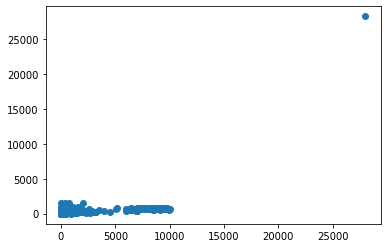

In [ ]:
plt.scatter(Y_train, predict_lr)

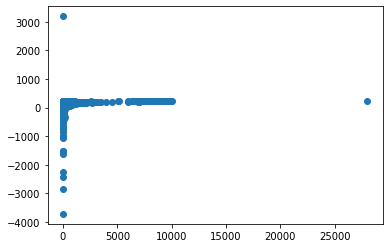

In [ ]:
lr.fit(X_norm_train, Y_norm_train)
lr.score(X_norm_train, Y_norm_train)
predict_lrn = lr.predict(X_norm_train)
plt.scatter(Y_norm_train, predict_lrn)

In [ ]:
from sklearn.linear_model import Lasso
lss = Lasso()

In [ ]:
lss.fit(X_train, Y_train)

Lasso()

In [ ]:
lss.score(X_train, Y_train) #Variance score

0.1603818461480303

In [ ]:
predict_lss = lss.predict(X_train)
print(predict_lss)

[140.88154528  79.69668968 160.84104601 ...  63.97466581 160.86558409
  49.92889001]


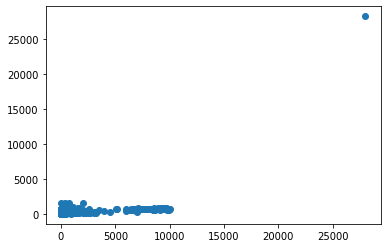

In [ ]:
plt.scatter(Y_train, predict_lss)

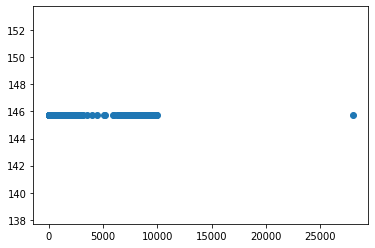

In [ ]:
lss.fit(X_norm_train, Y_norm_train)
lss.score(X_norm_train, Y_norm_train)
predict_lssn = lss.predict(X_norm_train)
plt.scatter(Y_norm_train, predict_lssn)

In [ ]:
from sklearn.linear_model import Ridge
rdg = Ridge()

In [ ]:
rdg.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.5432e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Ridge()

In [ ]:
rdg.score(X_train, Y_train)

0.1604776037761534

In [ ]:
predict_rdg = rdg.predict(X_train)
print(predict_rdg)

[127.27936738  79.66760954 161.93462224 ...  53.87414288 161.95916067
  34.14018998]


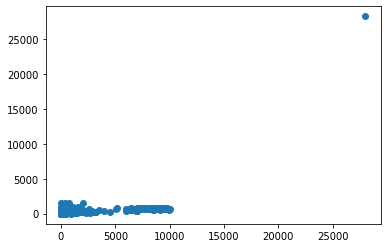

In [ ]:
plt.scatter(Y_train, predict_rdg)

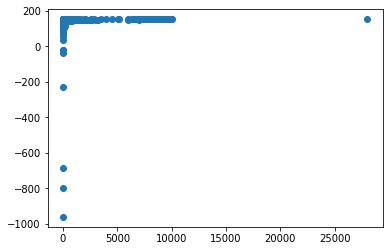

In [ ]:
rdg.fit(X_norm_train, Y_norm_train)
rdg.score(X_norm_train, Y_norm_train)
predict_rdgn = rdg.predict(X_norm_train)
plt.scatter(Y_norm_train, predict_rdgn)

In [ ]:
from sklearn.linear_model import ElasticNet
en = ElasticNet()

en.fit(X_train, Y_train)

ElasticNet()

In [ ]:
en.score(X_train, Y_train)

0.12015464876956827

In [ ]:
predict_en = en.predict(X_train)
print(predict_en)

[189.58743207 115.81868746 165.19668749 ... 155.62043557 165.22123623
 131.57118224]


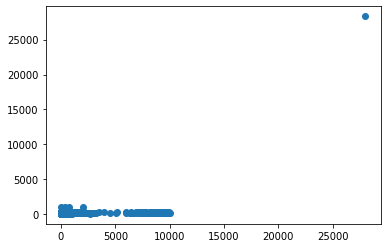

In [ ]:
 plt.scatter(Y_train, predict_en)

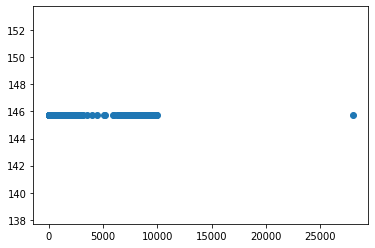

In [ ]:
en.fit(X_norm_train, Y_norm_train)
en.score(X_norm_train, Y_norm_train)
predict_enn = en.predict(X_norm_train)
plt.scatter(Y_norm_train, predict_enn)

### Gradient Boosting Regressor

In [ ]:
xgbr = XGBRegressor()
xgbr.fit(X_train, Y_train)
xgbr.score(X_train,Y_train)

[12:59:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9474624242526161

In [ ]:
predict_xgbr = xgbr.predict(X_train)

In [ ]:
r2_score(Y_train, predict_xgbr)

0.9474624242526161

In [ ]:
mean_absolute_error(Y_train, predict_xgbr)

57.00104749270489

In [ ]:
mean_squared_error(Y_train, predict_xgbr)

22333.024453981197

In [ ]:
mean_absolute_percentage_error(Y_train, predict_xgbr)

0.7192098440395773

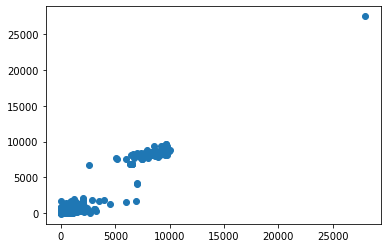

In [ ]:
plt.scatter(Y_train, predict_xgbr)

In [ ]:
# Predicting the test dataset using Linear Regression

print(lr.predict(X_norm_test))

[153.96552728 148.16051549 138.20130648 ... 160.40878779 160.0235528
 107.06251601]


In [ ]:
# Predicting the test dataset using Ridge


print(rdg.predict(X_norm_test))

[146.12275442 145.49030158 144.33277553 ... 146.7973577  146.08200973
 144.45254273]


In [ ]:
# Predicting the test dataset using Ridge


print(xgbr.predict(X_test))

[ 87.791145 122.846794  25.944853 ... 275.55588   60.79747   93.4191  ]


## References